In [126]:
# Importation des bibliothèques nécessaires
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Chargement des données (ici tu pourrais charger un fichier CSV)
data = pd.read_excel('data.xlsx')

# Préparation des données
# On retire les colonnes non pertinentes pour la prédiction
data = data.drop(['Libellé.de.la.commune', 'Libellé.de.la.circonscription'], axis=1)

# Clustering (KMeans) pour regrouper les communes en 3 clusters
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[['Inscrits', 'tx_chom_hist', 'pourcentage_Abstentions']])
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(data_scaled)

# Définir les couleurs pour chaque cluster
# Assurez-vous que toutes les clés correspondent aux valeurs uniques dans la colonne 'Cluster'
cluster_colors = {0: 'blue', 1: 'red', 2: 'yellow'}

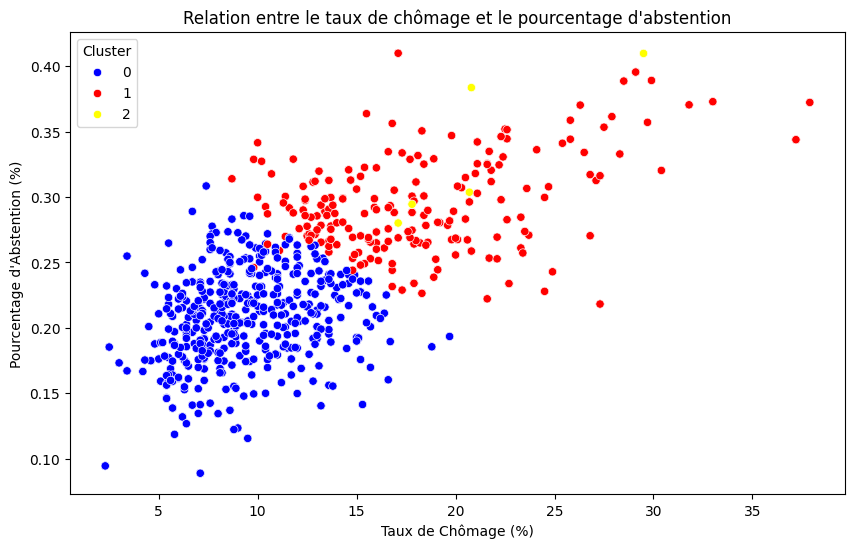

In [127]:
# Visualisation 1 : Relation entre le taux de chômage et le pourcentage d'abstention
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tx_chom_hist', y='pourcentage_Abstentions', hue='Cluster', palette=cluster_colors, data=data, legend='full')
plt.title('Relation entre le taux de chômage et le pourcentage d\'abstention')
plt.xlabel('Taux de Chômage (%)')
plt.ylabel('Pourcentage d\'Abstention (%)')
plt.legend(title='Cluster')
plt.show()

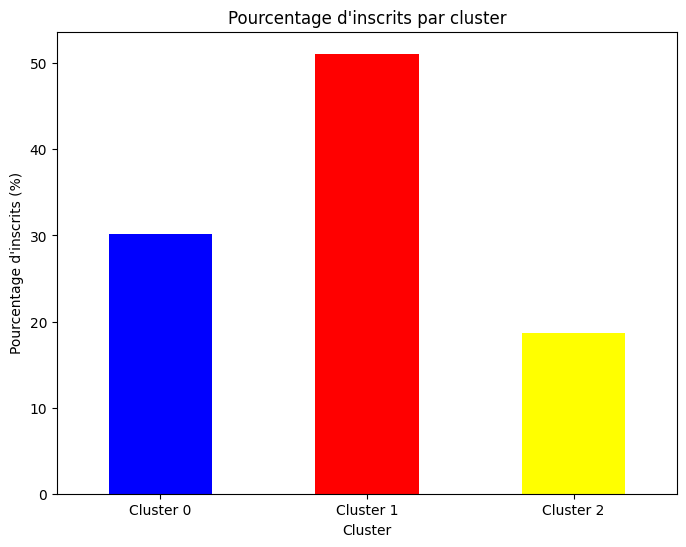

In [128]:
# pourcentage inscrits par cluster
total_inscrits = data['Inscrits'].sum()
cluster_inscrits = data.groupby('Cluster')['Inscrits'].sum()
cluster_percentages = (cluster_inscrits / total_inscrits) * 100

#Graph 2 : Pourcentage d'inscrits par cluster
plt.figure(figsize=(8, 6))
cluster_percentages.plot(kind='bar', color=['blue', 'red', 'yellow'])
plt.title('Pourcentage d\'inscrits par cluster')
plt.xlabel('Cluster')
plt.ylabel('Pourcentage d\'inscrits (%)')
plt.xticks(ticks=range(3), labels=[f'Cluster {i}' for i in range(3)], rotation=0)
plt.show()

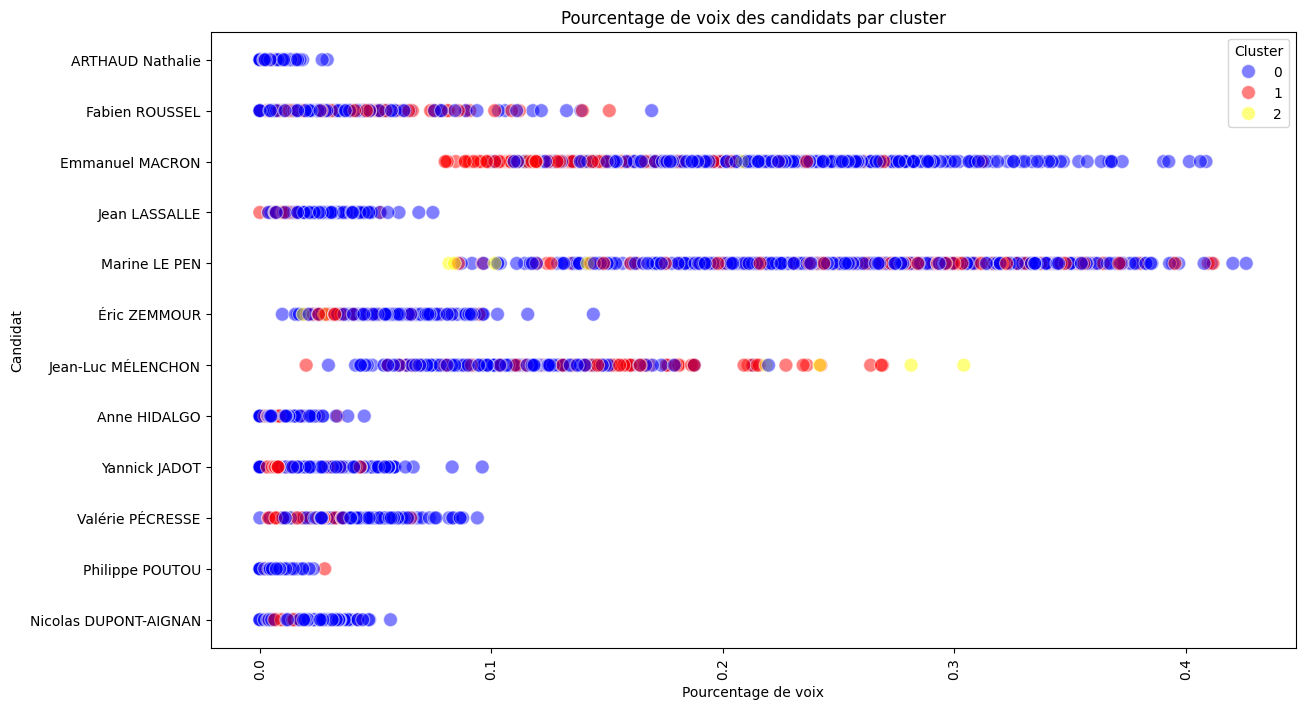

In [129]:


cluster_colors = {0: 'blue', 1: 'red', 2: 'yellow'}

plt.figure(figsize=(14, 8))
sns.scatterplot(x='pourcentage_Voix', y='Nom_Prenom', hue='Cluster', palette=cluster_colors, data=data, s=100, alpha=0.5)  # Opacité réduite
plt.title('Pourcentage de voix des candidats par cluster')
plt.xlabel('Pourcentage de voix')
plt.ylabel('Candidat')
plt.xticks(rotation=90)
plt.legend(title='Cluster')
plt.show()


In [130]:
#Ajout des gagnants du premier tour

data['Nombre_Voix'] = data['Inscrits'] * data['pourcentage_Voix']
data['Gagnant_premier_tour'] = data['Nom_Prenom'].apply(
    lambda x: 1 if x in ['Emmanuel MACRON', 'Marine LE PEN'] else 0
)

Train target distribution:
 Gagnant_premier_tour
0    5166
1    1016
Name: count, dtype: int64
Test target distribution:
 Gagnant_premier_tour
0    1274
1     272
Name: count, dtype: int64
Accuracy: 0.82
Cross-validation scores: [0.83311772 0.83311772 0.83311772 0.83365696 0.83365696]
Importance des variables :
                   Feature  Importance
8    Niveau de vie Commune    0.127131
3       pourcentage_Blancs    0.120336
4         pourcentage_Nuls    0.116837
7                    p_pop    0.111348
0                 Inscrits    0.110941
6             tx_chom_hist    0.109474
5     pourcentage_Exprimés    0.103056
1  pourcentage_Abstentions    0.101258
2      pourcentage_Votants    0.099620


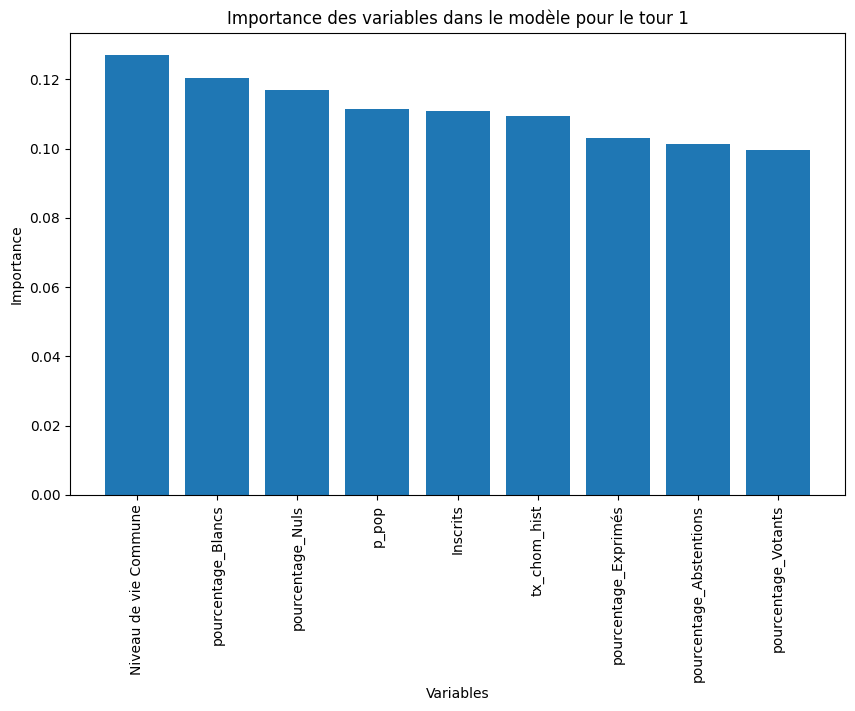

In [133]:

# Convertir les pourcentages en valeurs en pourcentage (x100)
percentage_columns = ['pourcentage_Abstentions', 'pourcentage_Votants', 'pourcentage_Blancs', 
                      'pourcentage_Nuls', 'pourcentage_Exprimés', 'pourcentage_Voix']
data[percentage_columns] = data[percentage_columns].multiply(100)

# Convertir les données non numériques
data['Niveau de vie Commune'] = pd.to_numeric(data['Niveau de vie Commune'], errors='coerce')

# Sélectionner les colonnes pour le modèle
feature_columns = ['Inscrits', 'pourcentage_Abstentions', 'pourcentage_Votants', 
                   'pourcentage_Blancs', 'pourcentage_Nuls', 'pourcentage_Exprimés', 'tx_chom_hist', 'p_pop', 'Niveau de vie Commune']

X = data[feature_columns]
y = data['Gagnant_premier_tour']

# Imputation des valeurs manquantes pour RandomForest
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Division des données en un ensemble d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Vérification de l'équilibre des classes
print("Train target distribution:\n", y_train.value_counts())
print("Test target distribution:\n", y_test.value_counts())

# Création du modèle
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraînement du modèle
model.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluation du modèle
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f' % accuracy)

# Validation croisée
cross_val_scores = cross_val_score(model, X_scaled, y, cv=5)
print("Cross-validation scores:", cross_val_scores)

# Obtention de l'importance des variables
importances = model.feature_importances_

# Création d'un DataFrame pour l'importance des variables
feature_names = feature_columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Affichage de l'importance des variables
print("Importance des variables :")
print(importance_df)

# Création d'un graphique à barres pour visualiser l'importance des variables
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xticks(rotation='vertical')
plt.xlabel('Variables')
plt.ylabel('Importance')
plt.title('Importance des variables dans le modèle pour le tour 1')
plt.show()
